# Location and Time Exploration

In this notebook, I aim to draw insights on efficiency depending on time and location of rides that have been aggregated

Data:
- Matched ride and efficiency data outputted from the Efficiency Exploration.ipynb notebook: matched rides.csv
- Shapefile for neighborhoods: https://data.cityofnewyork.us/City-Government/Neighborhood-Tabulation-Areas-NTA-/cpf4-rkhq


In [1]:
import pandas as pd
import numpy as np
import datetime
import math
from pyproj import Geod
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

#bringing in the aggregated rides to analyze (output of efficiency exploration)
df = pd.read_csv('matched rides.csv').drop(['matches'],1) 

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.pickup_longitude, df.pickup_latitude)) #turn to geopandas
neighborhoods = "Neighborhood Tabulation Areas (NTA)/geo_export_b41a84af-cff4-4549-a90c-92f6a8161827.shp" #bring in shapemap

data = gpd.read_file(neighborhoods)[['geometry','ntaname','boro_name']] #turn into geopandas dataframe 
df = gpd.sjoin(gdf, data, how="inner", op='intersects') #spatial join to map to neighborhood
df['tpep_pickup_datetime']=pd.to_datetime(df['tpep_pickup_datetime']) #convert pickup to datetime
df.reset_index(drop=True,inplace=True)

df.head()

,fare_amount,duration,passenger_count,tpep_pickup_datetime,pickup_latitude,pickup_longitude,cars combined,new fare,driver cost saved,new duration,fare difference,duration difference,profit difference,geometry,index_right,ntaname,boro_name
0,14.0,12.333333,2,2016-06-06 00:44:03,40.733292,-73.991173,2,14,3.083333,16.333333,0.0,4.0,3.083333,POINT (-73.99117 40.73329),86,West Village,Manhattan
1,16.5,15.600000,3,2016-06-06 00:31:52,40.740486,-74.008392,2,21,3.900000,21.600000,4.5,6.0,8.400000,POINT (-74.00839 40.74049),86,West Village,Manhattan
2,13.0,12.216667,3,2016-06-06 01:25:13,40.739971,-74.005882,2,21,3.054167,18.216667,8.0,6.0,11.054167,POINT (-74.00588 40.73997),86,West Village,Manhattan
3,46.5,49.233333,3,2016-06-06 00:58:38,40.739471,-74.010002,2,21,12.308333,55.233333,-25.5,6.0,-13.191667,POINT (-74.01000 40.73947),86,West Village,Manhattan
4,14.0,10.283333,2,2016-06-06 06:35:22,40.731651,-74.000992,2,14,2.570833,14.283333,0.0,4.0,2.570833,POINT (-74.00099 40.73165),86,West Village,Manhattan


# Time 

Taking a look at times that our rides were aggregated, and when they were efficienct in terms of profit and ride duration

### When were our Aggregated Rides

Text(0.5, 1.0, 'Aggregated rides by Day of Week')

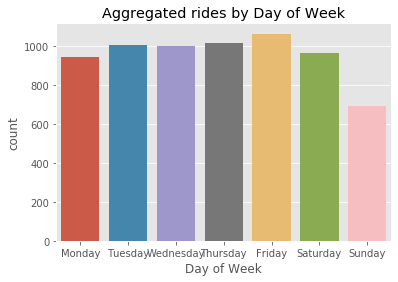

In [2]:
df['Day of Week']=df['tpep_pickup_datetime'].dt.day_name()
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

figure,ax=plt.subplots()
sns.countplot(x='Day of Week',data=df,order=day_order)
ax.set_title('Aggregated rides by Day of Week')

In [3]:
#avg revenue increase for individual rides after aggregated
df.groupby('Day of Week')['profit difference'].mean().sort_values().round(2)

Day of Week
Wednesday    1.77
Thursday     1.93
Friday       2.57
Tuesday      3.02
Saturday     4.08
Monday       4.34
Sunday       4.66
Name: profit difference, dtype: float64

In [4]:
#avg duration of ride increase for rides after aggregated
df.groupby('Day of Week')['duration difference'].mean().sort_values().round(2)

Day of Week
Monday       4.91
Wednesday    4.92
Thursday     4.98
Tuesday      5.00
Friday       5.02
Saturday     5.24
Sunday       5.25
Name: duration difference, dtype: float64

Text(0.5, 1.0, 'Aggregated rides by time of day')

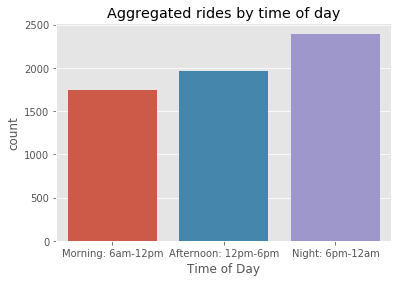

In [5]:
def timeFrame(time):
    if time.hour >= 6 and time.hour <12 :
        return 'Morning: 6am-12pm'
    elif time.hour >= 12 and time.hour < 18:
        return 'Afternoon: 12pm-6pm'
    elif time.hour >= 18 and time.hour < 24:
        return 'Night: 6pm-12am'
    elif time.hour >= 24 and time.hour < 6: 
        return 'Early Morning: 12am-6am'
    
df['Time of Day']=df['tpep_pickup_datetime'].apply(lambda x :timeFrame(x))
time_order = ['Morning: 6am-12pm','Afternoon: 12pm-6pm','Night: 6pm-12am'] #minimal early morning data in subset

figure,ax=plt.subplots()
sns.countplot(x='Time of Day',data=df,order = time_order)
ax.set_title('Aggregated rides by time of day')

In [6]:
#avg revenue increase for rides before and after aggregated
df.groupby('Time of Day')['profit difference'].mean().sort_values().round(2)

Time of Day
Morning: 6am-12pm      2.41
Afternoon: 12pm-6pm    3.32
Night: 6pm-12am        3.73
Name: profit difference, dtype: float64

In [7]:
#avg duration of ride increase for rides before and after aggregated
df.groupby('Time of Day')['duration difference'].mean().sort_values().round(2)

Time of Day
Morning: 6am-12pm      4.87
Afternoon: 12pm-6pm    5.08
Night: 6pm-12am        5.09
Name: duration difference, dtype: float64

# Location 

Taking a look at neighborhoods/locations that our rides were aggregated, and where they efficienct in terms of profit and ride duration

### Where Were Our Aggregated Rides

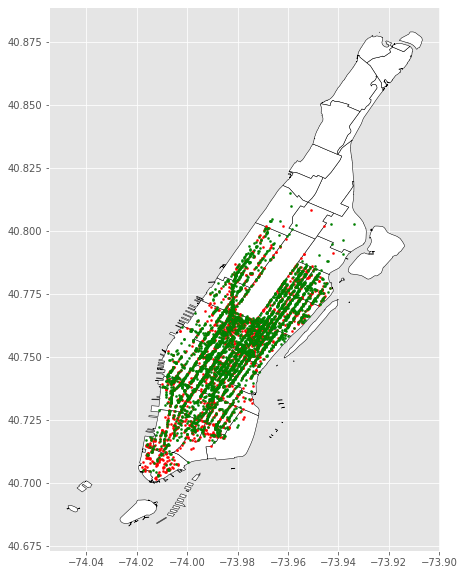

In [8]:
manhattan = data[data['boro_name']=='Manhattan']
base = manhattan.plot(color='white', edgecolor='black',figsize=(15, 10))

low_profit_zones = df[df['profit difference']<0] #rides that lost money
high_profit_zones = df[df['profit difference']>2] #rides that made > $2 total from ride on avg

low_profit_zones.plot(ax=base, marker='o', color='red', markersize=4);
high_profit_zones.plot(ax=base, marker='o', color='green', markersize=4);


In [9]:
#change in avg profit per ride based on neighborhood
df_relevant = df[df.groupby('ntaname')['ntaname'].transform('size') > 90] #areas with enough data
df_relevant.groupby('ntaname')['profit difference'].mean().sort_values().round(2)

ntaname
Battery Park City-Lower Manhattan            -4.96
Chinatown                                     0.01
East Village                                  1.34
SoHo-TriBeCa-Civic Center-Little Italy        1.81
Gramercy                                      2.55
Yorkville                                     2.56
Turtle Bay-East Midtown                       2.85
West Village                                  2.89
park-cemetery-etc-Manhattan                   2.93
Lenox Hill-Roosevelt Island                   3.12
Midtown-Midtown South                         3.42
Clinton                                       3.46
Hudson Yards-Chelsea-Flatiron-Union Square    3.66
Upper East Side-Carnegie Hill                 4.05
Murray Hill-Kips Bay                          4.61
Lincoln Square                                4.82
Upper West Side                               4.91
Name: profit difference, dtype: float64

In [10]:
#change in avg duration per ride based on neighborhood
df_relevant.groupby('ntaname')['duration difference'].mean().sort_values().round(2)

ntaname
Yorkville                                     4.81
Clinton                                       4.85
Gramercy                                      4.92
Lincoln Square                                4.98
Upper West Side                               4.99
Upper East Side-Carnegie Hill                 5.00
Murray Hill-Kips Bay                          5.00
Hudson Yards-Chelsea-Flatiron-Union Square    5.03
Turtle Bay-East Midtown                       5.05
West Village                                  5.06
SoHo-TriBeCa-Civic Center-Little Italy        5.07
Lenox Hill-Roosevelt Island                   5.08
Battery Park City-Lower Manhattan             5.09
Midtown-Midtown South                         5.09
East Village                                  5.12
park-cemetery-etc-Manhattan                   5.25
Chinatown                                     5.28
Name: duration difference, dtype: float64

In [11]:
#low profit zones based on ride duration (want to see if duration is factor of these zones being low profit)
df_relevant[df_relevant['profit difference']<1]['new duration'].mean().round(2)

43.06

In [12]:
#profitable zones based on ride duration
df_relevant[df_relevant['profit difference']>1]['new duration'].mean().round(2)

31.33

In [13]:
#original ride duration by neighborhood before aggregation
df_relevant.groupby('ntaname')['duration'].mean().sort_values().round(2)

ntaname
Yorkville                                     23.68
Lenox Hill-Roosevelt Island                   25.42
Gramercy                                      26.42
Upper East Side-Carnegie Hill                 27.46
Upper West Side                               27.51
Turtle Bay-East Midtown                       28.24
Hudson Yards-Chelsea-Flatiron-Union Square    28.26
East Village                                  28.38
Clinton                                       29.32
Lincoln Square                                30.12
West Village                                  31.28
Chinatown                                     31.54
Murray Hill-Kips Bay                          34.32
Midtown-Midtown South                         34.51
park-cemetery-etc-Manhattan                   35.83
SoHo-TriBeCa-Civic Center-Little Italy        35.94
Battery Park City-Lower Manhattan             40.44
Name: duration, dtype: float64